<a href="https://colab.research.google.com/github/AtSourav/CatsnDogs_VAE/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras       # cannot use the name tf to import modules, can only use it to call functions or modules
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K
from keras.datasets import mnist

import os
import matplotlib.pyplot as plt


In [2]:
input_size = (14,14,1)
latent_dim = 2
batch_size = 32

#v_split = 0.1

In [3]:
(img_train, tg_train), (img_valid, tg_valid) = mnist.load_data()

img_ht = img_train.shape[1]         #the shape of the data is (count, ht, wd)
img_wd = img_train.shape[2]
count_train = img_train.shape[0]
count_valid = img_valid.shape[0]

img_train = img_train.reshape(count_train,img_ht,img_wd, 1)     # we are adding the channel axis manually
img_valid = img_valid.reshape(count_valid,img_ht,img_wd, 1)

print(img_train.shape)
print(img_valid.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [4]:
img_train = layers.Resizing(14, 14, interpolation="bilinear")(img_train)
img_valid = layers.Resizing(14, 14, interpolation="bilinear")(img_valid)


print(img_train.shape)
print(img_valid.shape)


(60000, 14, 14, 1)
(10000, 14, 14, 1)


In [5]:
for img in img_train[:5]:
  print(np.min(img), np.max(img))

img_train = img_train/255.
img_valid = img_valid/255.

for img in img_train[:5]:
  print(np.min(img), np.max(img))

0.0 253.0
0.0 253.25
0.0 244.0
0.0 252.0
0.0 252.5
0.0 0.99215686
0.0 0.99313724
0.0 0.95686275
0.0 0.9882353
0.0 0.99019605


In [6]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(16, 3, padding="valid")(encoder_input)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)    # with strides=None this defaults to pool_size
x = layers.BatchNormalization(axis=-1)(x) # the default data_format in the conv2d is "channels last", we want to normalize across the channels, hence we set axis=-1
x = layers.ReLU()(x)

#x = layers.Conv2D(32, 3, padding="valid")(x)
#x = layers.MaxPooling2D(pool_size=(2, 2), strides=1, padding="valid")(x)
#x = layers.BatchNormalization(axis=-1)(x)
#x = layers.ReLU()(x)

#x = layers.Conv2D(64, 2, padding="valid")(x)
#x = layers.MaxPooling2D(pool_size=(2, 2), strides=1, padding="valid")(x)
#x = layers.BatchNormalization(axis=-1)(x)
#x = layers.ReLU()(x)
x = layers.Flatten()(x)

#x = layers.Dense(8*latent_dim)(x)
x = layers.Dense(4*latent_dim)(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

def sampling(arg):
  z_m, z_log_v = arg
  batch = tf.shape(z_m)[0]
  dim = tf.shape(z_m)[1]
  eps = tf.random.normal(shape=(batch,dim))
  return z_m + tf.exp(0.5*z_log_v)*eps

z = layers.Lambda(sampling)([z_mean,z_log_var])   # we feed the sampling function in to a Lambda layer to build form a layer for the architecture as keras needs

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')           # the second argument specifies that the encoder outputs [z_mean, z_log_var, z] for each input.
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 14, 14, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 12, 12, 16)           160       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 6, 6, 16)             0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 6, 6, 16)             64        ['max_pooling2d[0][0]'] 

In [7]:
latent_input = keras.Input(shape=(latent_dim,))

#x = layers.Dense(4*latent_dim)(latent_input)
#x = layers.Dense(8*latent_dim)(x)

x = layers.Dense(1*32)(latent_input)
x = layers.ReLU()(x)
x = layers.Reshape((1,1,32))(x)

x = layers.Conv2DTranspose(16, 3, strides=3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(8, 3, strides=3, padding='same')(x)
x = layers.MaxPooling2D(pool_size=(3, 3), strides=1, padding="valid")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(1, 3, strides=2, activation='sigmoid',padding='same')(x)
#x = layers.MaxPooling2D(pool_size=(3, 3), strides=1, padding="valid")(x)
#x = layers.BatchNormalization()(x)
#x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(2, 4, strides=2, padding='same')(x)
#x = layers.MaxPooling2D(pool_size=(3, 3), strides=1, padding="valid")(x)
#x = layers.BatchNormalization()(x)
#x = layers.ReLU()(x)

#decoder_output = layers.Conv2DTranspose(1, 3, activation='sigmoid', strides=1, padding='same')(x)

decoder_output = x

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 32)                96        
                                                                 
 re_lu_1 (ReLU)              (None, 32)                0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 3, 3, 16)          4624      
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 3, 3, 16)          64        
 chNormalization)                                          

Now let's instantiate the VAE by combininb the encoder and the decoder layers.

In [8]:
decoder_out = decoder(encoder(encoder_input)[2])          # we feed in z from the encoder output
VAE = keras.Model(encoder_input, decoder_out, name='VAE')

VAE.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               4876      
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 14, 14, 1)         6049      
                                                                 
Total params: 10925 (42.68 KB)
Trainable params: 10845 (42.36 KB)
Non-trainable params: 80 (320.00 Byte)
_________________________________________________________________


We shall define the loss function now, it's made of the reconstruction loss that tries to ensure repoducibility of the data, and the KL divergence loss that tries to ensure that the learned (approximate) posterior is close to the true posterior. Since we have continuous values for the pixels, we cannot use the Bernoulli log loss (binary cross entropy) for the reconstruction loss, we shall use mean squared error. In a different version, we shall try to implement a continuous version of the Bernoulli log loss based on 1907.06845.

We shall keep a relative weight beta between the two terms in the total loss as a hyperparameter. We may want to investigate the effects of varying this hyperparameter eventually.

The custom loss function needs to be a callable of the form fn(true, pred) to be compatible with Model.compile() and Model.fit(). The reconstruction loss will calculate the mse between the true and predicted images directly. The kl divergence loss is a function of z_mean and z_log_var that will be used directly from the values while evaluating the forward pass. For further details, look up the source code for the compile() and fit() methods in the Model class, and also for train_step(), compute_loss(), and make_train_function()

In [9]:
beta = 1  # we shall vary this later

#@tf.function
def vae_loss(true,pred):
  mse = losses.MeanSquaredError()
  reconstruction_loss = mse(K.flatten(true),K.flatten(pred))    # the input and the output for the model, which are 160*160*3 images will be taken as true and pred, respectively.
                                                                                              # layers.Flatten() is not appropriate here as it works on (batch, ht, wd, chan) to give (batch, flattened)
                                                                                              # converting to a numpy ndarray seems tricky here, .numpy() does not seem to work since it seems like we're not in earger execution mode

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)/(14*14)    # summing along the columns with tf.reduce_sum, if we chose to take mean instead of sum at this step, we shouldn't multiply with the dimensions for the reconstruction loss.
                                                                                                                # taking the mean along the batches with tf.reduce_mean, the mse for the reconstruction loss also takes the mean along the batches

  return reconstruction_loss + beta*kl_div

In [10]:
optim = keras.optimizers.Adam(learning_rate = 0.0001)
VAE.compile(optimizer=optim,loss=vae_loss)                 # run_eagerly is None by default, so the compilation happens in graph mode

Now we want to load our dataset, and train the VAE on it. We shall use the cats and dogs img dataset from this [repo](https://github.com/AtSourav/CatsnDogs_VAE.git)

We have cloned the repo with the dataset here so we can access it directly.

We shall now make a train and validation dataset from the images in Dataset_aug folder.

In [11]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=15, steps_per_epoch=None)


Epoch 1/15
1875/1875 [==============================] - 28s 8ms/step - loss: 0.1359 - val_loss: 0.0921
Epoch 2/15
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0658 - val_loss: 0.0846
Epoch 3/15
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0502 - val_loss: 0.0866
Epoch 4/15
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0462 - val_loss: 0.0876
Epoch 5/15
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0439 - val_loss: 0.0870
Epoch 6/15
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0425 - val_loss: 0.0876
Epoch 7/15
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0416 - val_loss: 0.0881
Epoch 8/15
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0409 - val_loss: 0.0900
Epoch 9/15
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0404 - val_loss: 0.0895
Epoch 10/15
1875/1875 [==============================] - 13s 7ms/step - l

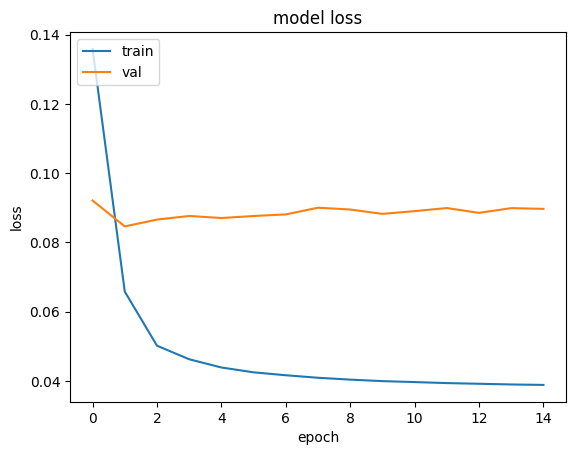

In [12]:
plt.plot(history.history['loss'])         # history.history is a dict with performance metrics as keys
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

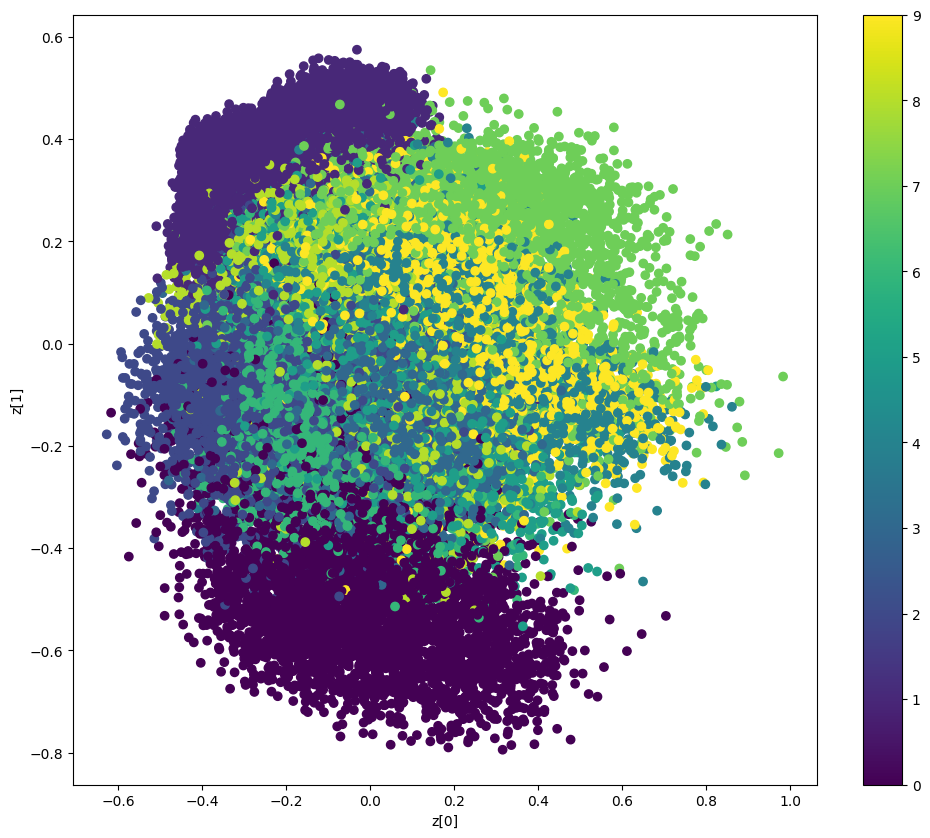

In [13]:
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()



plot_label_clusters(encoder, img_train,tg_train)
